## Let's start by installing and importing the libraries 

In [1]:
%%capture 
!pip install -U 'skillsnetwork' 'seaborn' 'nbformat' 

In [2]:
%%capture 
!pip install scikit-learn==1.0.0
!pip install dtreeviz

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.tree import export_text
import dtreeviz

#### Let's override the warn function to surpress libraries' warnings

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [6]:
import skillsnetwork
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context('notebook')
sns.set_style('white')

## Cyber Attack data

The data is collected by the [University of New South Wales (Australia)](https://research.unsw.edu.au/projects/unsw-nb15-dataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMSkillsNetworkGPXX0Q8REN2117-2023-01-01). encompassing various cyber attack records.

Let's load the data

In [7]:
training = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0Q8REN/UNSW_NB15_training-set.csv")
testing = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0Q8REN/UNSW_NB15_testing-set.csv")
print("training ",training.shape)
print("testing ",testing.shape)


training  (82332, 45)
testing  (175341, 45)


In [8]:
training.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


Let's concatenate the training and the testing data

In [9]:
df = pd.concat([training,testing]).drop('id',axis=1)
df = df.reset_index(drop=True)

In [10]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


Let's examine the different types of attacks and their protocols

In [11]:
df.attack_cat.unique()

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

In [12]:
df.proto.unique()

array(['udp', 'arp', 'tcp', 'igmp', 'ospf', 'sctp', 'gre', 'ggp', 'ip',
       'ipnip', 'st2', 'argus', 'chaos', 'egp', 'emcon', 'nvp', 'pup',
       'xnet', 'mux', 'dcn', 'hmp', 'prm', 'trunk-1', 'trunk-2',
       'xns-idp', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'netblt', 'mfe-nsp',
       'merit-inp', '3pc', 'idpr', 'ddp', 'idpr-cmtp', 'tp++', 'ipv6',
       'sdrp', 'ipv6-frag', 'ipv6-route', 'idrp', 'mhrp', 'i-nlsp', 'rvd',
       'mobile', 'narp', 'skip', 'tlsp', 'ipv6-no', 'any', 'ipv6-opts',
       'cftp', 'sat-expak', 'ippc', 'kryptolan', 'sat-mon', 'cpnx', 'wsn',
       'pvp', 'br-sat-mon', 'sun-nd', 'wb-mon', 'vmtp', 'ttp', 'vines',
       'nsfnet-igp', 'dgp', 'eigrp', 'tcf', 'sprite-rpc', 'larp', 'mtp',
       'ax.25', 'ipip', 'aes-sp3-d', 'micp', 'encap', 'pri-enc', 'gmtp',
       'ifmp', 'pnni', 'qnx', 'scps', 'cbt', 'bbn-rcc', 'igp', 'bna',
       'swipe', 'visa', 'ipcv', 'cphb', 'iso-tp4', 'wb-expak', 'sep',
       'secure-vmtp', 'xtp', 'il', 'rsvp', 'unas', 'fc', 'iso-ip',


## List of features with description

The data was processed using Argus and Bro-ID tools, resulting in 49 features with class labels.

|No.|Name            |Type     |Description                                                                                                                                                       |
|---|----------------|---------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|1  |srcip           |nominal  |Source IP address                                                                                                                                                 |
|2  |sport           |integer  |Source port number                                                                                                                                                |
|3  |dstip           |nominal  |Destination IP address                                                                                                                                            |
|4  |dsport          |integer  |Destination port number                                                                                                                                           |
|5  |proto           |nominal  |Transaction protocol                                                                                                                                              |
|6  |state           |nominal  |Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)    |
|7  |dur             |Float    |Record total duration                                                                                                                                             |
|8  |sbytes          |Integer  |Source to destination transaction bytes                                                                                                                           |
|9  |dbytes          |Integer  |Destination to source transaction bytes                                                                                                                           |
|10 |sttl            |Integer  |Source to destination time to live value                                                                                                                          |
|11 |dttl            |Integer  |Destination to source time to live value                                                                                                                          |
|12 |sloss           |Integer  |Source packets retransmitted or dropped                                                                                                                           |
|13 |dloss           |Integer  |Destination packets retransmitted or dropped                                                                                                                      |
|14 |service         |nominal  |http, ftp, smtp, ssh, dns, ftp-data ,irc  and (-) if not much used service                                                                                        |
|15 |Sload           |Float    |Source bits per second                                                                                                                                            |
|16 |Dload           |Float    |Destination bits per second                                                                                                                                       |
|17 |Spkts           |integer  |Source to destination packet count                                                                                                                                |
|18 |Dpkts           |integer  |Destination to source packet count                                                                                                                                |
|19 |swin            |integer  |Source TCP window advertisement value                                                                                                                             |
|20 |dwin            |integer  |Destination TCP window advertisement value                                                                                                                        |
|21 |stcpb           |integer  |Source TCP base sequence number                                                                                                                                   |
|22 |dtcpb           |integer  |Destination TCP base sequence number                                                                                                                              |
|23 |smeansz         |integer  |Mean of the ?ow packet size transmitted by the src                                                                                                                |
|24 |dmeansz         |integer  |Mean of the ?ow packet size transmitted by the dst                                                                                                                |
|25 |trans_depth     |integer  |Represents the pipelined depth into the connection of http request/response transaction                                                                           |
|26 |res_bdy_len     |integer  |Actual uncompressed content size of the data transferred from the serverís http service.                                                                          |
|27 |Sjit            |Float    |Source jitter (mSec)                                                                                                                                              |
|28 |Djit            |Float    |Destination jitter (mSec)                                                                                                                                         |
|29 |Stime           |Timestamp|record start time                                                                                                                                                 |
|30 |Ltime           |Timestamp|record last time                                                                                                                                                  |
|31 |Sintpkt         |Float    |Source interpacket arrival time (mSec)                                                                                                                            |
|32 |Dintpkt         |Float    |Destination interpacket arrival time (mSec)                                                                                                                       |
|33 |tcprtt          |Float    |TCP connection setup round-trip time, the sum of ísynackí and íackdatí.                                                                                           |
|34 |synack          |Float    |TCP connection setup time, the time between the SYN and the SYN_ACK packets.                                                                                      |
|35 |ackdat          |Float    |TCP connection setup time, the time between the SYN_ACK and the ACK packets.                                                                                      |
|36 |is_sm_ips_ports |Binary   |If source (1) and destination (3)IP addresses equal and port numbers (2)(4)  equal then, this variable takes value 1 else 0                                       |
|37 |ct_state_ttl    |Integer  |No. for each state (6) according to specific range of values for source/destination time to live (10) (11).                                                       |
|38 |ct_flw_http_mthd|Integer  |No. of flows that has methods such as Get and Post in http service.                                                                                               |
|39 |is_ftp_login    |Binary   |If the ftp session is accessed by user and password then 1 else 0.                                                                                                |
|40 |ct_ftp_cmd      |integer  |No of flows that has a command in ftp session.                                                                                                                    |
|41 |ct_srv_src      |integer  |No. of connections that contain the same service (14) and source address (1) in 100 connections according to the last time (26).                                  |
|42 |ct_srv_dst      |integer  |No. of connections that contain the same service (14) and destination address (3) in 100 connections according to the last time (26).                             |
|43 |ct_dst_ltm      |integer  |No. of connections of the same destination address (3) in 100 connections according to the last time (26).                                                        |
|44 |ct_src_ ltm     |integer  |No. of connections of the same source address (1) in 100 connections according to the last time (26).                                                             |
|45 |ct_src_dport_ltm|integer  |No of connections of the same source address (1) and the destination port (4) in 100 connections according to the last time (26).                                 |
|46 |ct_dst_sport_ltm|integer  |No of connections of the same destination address (3) and the source port (2) in 100 connections according to the last time (26).                                 |
|47 |ct_dst_src_ltm  |integer  |No of connections of the same source (1) and the destination (3) address in in 100 connections according to the last time (26).                                   |
|48 |attack_cat      |nominal  |The name of each attack category. In this data set , nine categories e.g. Fuzzers, Analysis, Backdoors, DoS Exploits, Generic, Reconnaissance, Shellcode and Worms|
|49 |Label           |binary   |0 for normal and 1 for attack records                                                                                                                             |


## EDA

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  di

#### We need to change some columns (proto, state, service, attack_cat) from string to categorical  

In [14]:
#convert columns to numerical codes
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes
    df[col] = df[col].astype('category').cat.codes
    
#convert to categorical
df['attack_cat'] = df['attack_cat'].astype('category')

In [15]:
# explore different types of attackes
attack_counts = df[df['label'] == 1]['attack_cat'].value_counts()
attack_counts

Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Normal                0
Name: attack_cat, dtype: int64

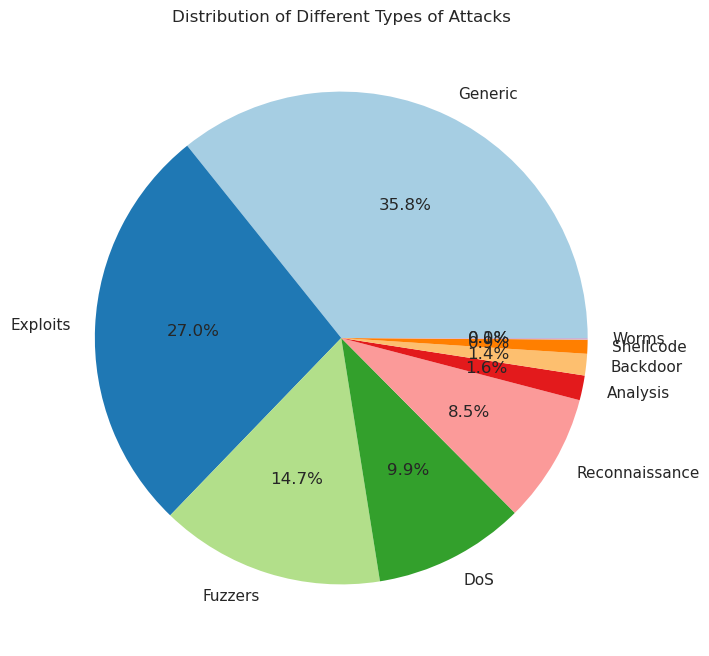

In [16]:
plt.figure(figsize=(8, 8))
colors = plt.cm.Paired(range(len(attack_counts) -1))
attack_counts.plot(kind='pie', autopct='%1.1f%%', wedgeprops={'linewidth': 0, 'edgecolor': 'white', 'width': 1}, colors=colors)
plt.title('Distribution of Different Types of Attacks')
plt.ylabel('')  # Remove the ylabel which contains the column name 'attack_cat'
plt.show()

## Rule based system

Rule based systems are more interpretable, they will be our first layer of detection

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into variables and target variables
# let's exclude label columns
X = df.loc[:, ~df.columns.isin(['attack_cat', 'label'])]
y = df['label'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

# Getting the list of variables
feature_names = list(X.columns)

# print the shape of train and test data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (180371, 42)
y_train shape:  (180371,)
X_test shape:  (77302, 42)
y_test shape:  (77302,)


I will use a decision tree model for detecting cyber attacks in the rule-based system. The goal of this first layer of protection is to have a high recall rate, since the priority is to minimize false negatives.

In [18]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

dt = DecisionTreeClassifier()

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 4],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4]},
             scoring='recall')

In [19]:
print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 1.0


Let's use this parametrs : 

In [20]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

clf=grid_search.best_estimator_
#same as
#clf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1, min_samples_split=2, criterion= 'entropy')
#clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the mean absolute error of the model
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

Recall:  1.0


Let's visualize the rules using dtreeviz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Our rules :  
 |--- sttl <= 61.00
|   |--- sinpkt <= 0.00
|   |   |--- class: 1
|   |--- sinpkt >  0.00
|   |   |--- class: 0
|--- sttl >  61.00
|   |--- synack <= 0.04
|   |   |--- class: 1
|   |--- synack >  0.04
|   |   |--- class: 1



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


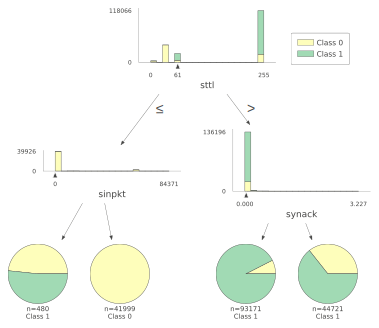

In [21]:
print("Our rules :  \n" ,export_text(clf,feature_names=feature_names))

viz_model = dtreeviz.model(clf,
                           X_train=X_train, y_train=y_train, 
                           feature_names=feature_names)

v = viz_model.view(fancy=True)     # render as SVG into internal object 
v

This is our first testing layer for detecting potential risks, we need to keep only the data 

In [22]:
X_test = X_test.reset_index(drop=True)

# filter out testing part based on our rules
rules= "(sttl <= 61.00 & sinpkt<= 0.00) | (sttl >  61.00 )"

# getting the index of records to keep
ind = X_test.query(rules).index

# filtering test set (both X_test and y_test)
X_test_2 = X_test.loc[ind,:]
y_test_2 = y_test[ind]

print(X_test.shape)
print(X_test_2.shape)
print("filtered data" , (1- np.round(X_test_2.shape[0] / X_test.shape[0],2))*100, "%")

(77302, 42)
(59425, 42)
filtered data 23.0 %


Our rule-based system detected 23% of network traffic for further analysis as a potential attack, I will next use snort, a free open source network intrusion detection system (NIDS)

## Using Machine Learning

Machine Learning models can identify more complex patterns in data, it can quickly analyze large datasets, it also provides more scalability than Rule Based system 

The high accuracy of Random Forest in identifying intricate data patterns makes it an excellent option for attack detection.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

# Create a Random Forest model
rf = RandomForestClassifier(random_state=123)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_2)

# Calculate the mean absolute error of the model
acc = accuracy_score(y_test_2, y_pred)
rec = recall_score(y_test_2, y_pred)
per = precision_score(y_test_2, y_pred)
print("Recall: ", rec)
print("Percision: ", per)
print("Accuracy: ", acc)

Recall:  0.9574644358228257
Percision:  0.964559074993893
Accuracy:  0.9352797644089188


the random forest algorithm demonstrated strong performance in detecting cyber attacks.

let's plot a confusion matrix : 

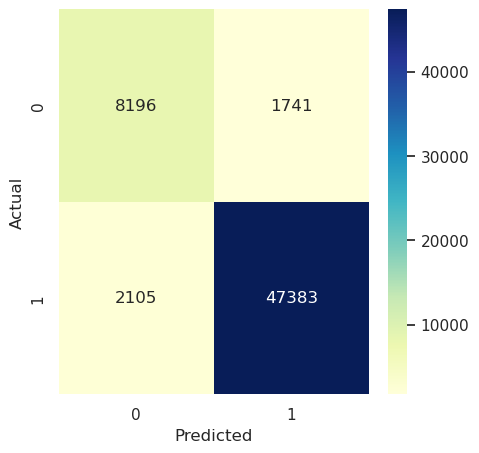

In [24]:
# plot confusion matrix
cross = pd.crosstab(pd.Series(y_test_2, name='Actual'), pd.Series(y_pred, name='Predicted'))
plt.figure(figsize=(5, 5))
sns.heatmap(cross, annot=True,fmt='d', cmap="YlGnBu")
plt.show()